In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, './MotorNet/')
import motornet as mn
import tensorflow as tf
from utils import Kernel_Gaussian

In [4]:
plant = mn.plants.ReluPointMass24()
print("Muscle Configuration:")
print(plant.get_muscle_cfg())

Muscle Configuration:
{'UpperRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'UpperLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}}


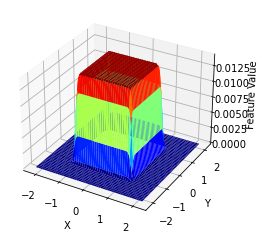

In [818]:
%matplotlib inline
x_range = np.array([-1.2,1.2])
y_range = np.array([-1.2,1.2])
n_kernel = 50
S = 0.005*np.eye(2)  
do_plot = 1
Kernel = Kernel_Gaussian(x_range, y_range, n_kernel, S, do_plot=1)


In [813]:
class SingleReach:
    def __init__(self, type):
        if type == 'fix':
            self.target_pos = np.array([0.5,0.6])
        if type == 'random':
            self.target_pos = (2*np.random.rand(2,1)) - 1

        self.target_size = 0.02
        self.dwell_time = 20
        self.hand_in = False
        self.trial_state = 0    # State of trial:  -1 loss, 0 still going, 1 Finished
        self.dwell_counter = 0
        self.screen = self.target_pos
        
    def get_reward(self, arm_pos):
        # Hand out of the target
        if np.linalg.norm(arm_pos-self.target_pos) >= self.target_size:
            if self.hand_in == True:
                self.reward = -10
                self.trial_state = -1
            else:
                self.reward = - np.linalg.norm(arm_pos-self.target_pos)
        # Hand in the target
        else:
            # First time
            if self.hand_in == False:
                self.reward = 0
                self.hand_in = True
                self.dwell_counter += 1
            # Has been in before
            else:
                if self.dwell_counter < self.dwell_time:
                    self.reward = 0
                    self.dwell_counter += 1
                else:
                    self.reward = 10
                    self.trial_state = 1
                    self.dwell_counter += 1
        return self.reward, self.target_pos, self.trial_state

In [819]:
class SeqEnv:
    def __init__(self, plant,visual_kernel, task, **kwargs):
        self.plant = plant
        self.task = task
        self.visual_kernel = visual_kernel
        self.plant.excitation_noise_sd=  kwargs.get('motor_noise_sd', 0)
        self.num_muscle = self.plant.n_muscles
        [self.joint_state, self.cart_state, self.muscle_state, self.geometry_state] = plant.get_initial_state(batch_size=1)

    def step(self, muscle_input):
        [self.joint_state, self.cart_state, self.muscle_state, self.geometry_state] = \
        self.plant(tf.convert_to_tensor(muscle_input,dtype='float') ,self.joint_state, self.muscle_state, self.geometry_state)
        self.reward, self.target_pos, self.trial_state = self.task.get_reward(self.cart_state.numpy()[0][:2])

        target_visual = self.visual_kernel.encode(self.target_pos[0].reshape(-1,1), self.target_pos[1].reshape(-1,1))
        hand_visual = self.visual_kernel.encode(self.cart_state.numpy()[0][0].reshape(-1,1), self.cart_state.numpy()[0][0].reshape(-1,1))
        self.visual_feedback = np.concatenate((target_visual, hand_visual),axis=0)
        
        return self.reward, self.visual_feedback, self.trial_state


In [820]:
task = SingleReach(type='fix')
env = SeqEnv(plant, Kernel, task, motor_noise_sd = 0)

In [835]:
vis.shape

(2, 2500)

-0.2270348873255907
0


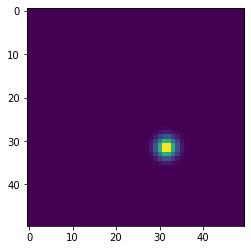

In [881]:
rew, vis, state = env.step([0,0,0,1])
#plt.imshow(vis[0].reshape(5,5))
plt.imshow(vis[1].reshape(50,50))
print(rew)
print(state)